Read the readme.md file first.
EDA:

In [2]:
import pandas as pd
import numpy as np
#plotting and statistical packages
import matplotlib as mpl
import matplotlib.pyplot as plt
import scipy as sp
import seaborn as sns
#display graphs in notebook
%matplotlib inline
#displays a load bar for tracking loop time processing
from tqdm import tqdm


In [3]:
#lets load the first chunk of data and look around
instacart_file=pd.read_csv('Data/orders.csv')
df_orders=pd.DataFrame(instacart_file,)
df_orders.head(12)


,order_id,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order
0,2539329,1,prior,1,2,8,NaN
1,2398795,1,prior,2,3,7,15.0
2,473747,1,prior,3,3,12,21.0
3,2254736,1,prior,4,4,7,29.0
4,431534,1,prior,5,4,15,28.0
5,3367565,1,prior,6,2,7,19.0
6,550135,1,prior,7,1,9,20.0
7,3108588,1,prior,8,1,14,14.0
8,2295261,1,prior,9,1,16,0.0
9,2550362,1,prior,10,4,8,30.0


In [4]:
df_orders.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3421083 entries, 0 to 3421082
Data columns (total 7 columns):
order_id                  int64
user_id                   int64
eval_set                  object
order_number              int64
order_dow                 int64
order_hour_of_day         int64
days_since_prior_order    float64
dtypes: float64(1), int64(5), object(1)
memory usage: 182.7+ MB


The eval_set has broken data down to a prior data set, a training set and a test set. (see data readme.md for more details data (column meaings, NaN useage, and data useage terms and conditions).

Lets segregate our data in order to keep the test data fresh and uncontaminated. We'll explore around in the prior data set to get an idea about the data. Then look at setting up the mechanics for the recommendor.

In [5]:
df_prior_set=df_orders[df_orders['eval_set']=='prior']
df_prior_set.head()

,order_id,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order
0,2539329,1,prior,1,2,8,NaN
1,2398795,1,prior,2,3,7,15.0
2,473747,1,prior,3,3,12,21.0
3,2254736,1,prior,4,4,7,29.0
4,431534,1,prior,5,4,15,28.0


In [6]:
df_train_set=df_orders[df_orders['eval_set']=='train']
df_train_set.head()

,order_id,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order
10,1187899,1,train,11,4,8,14.0
25,1492625,2,train,15,1,11,30.0
49,2196797,5,train,5,0,11,6.0
74,525192,7,train,21,2,11,6.0
78,880375,8,train,4,1,14,10.0


In [7]:
df_test_set=df_orders[df_orders['eval_set']=='test']
df_test_set.head()

,order_id,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order
38,2774568,3,test,13,5,15,11.0
44,329954,4,test,6,3,12,30.0
53,1528013,6,test,4,3,16,22.0
96,1376945,11,test,8,6,11,8.0
102,1356845,12,test,6,1,20,30.0


In [8]:
df_prior_set.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3214874 entries, 0 to 3421081
Data columns (total 7 columns):
order_id                  int64
user_id                   int64
eval_set                  object
order_number              int64
order_dow                 int64
order_hour_of_day         int64
days_since_prior_order    float64
dtypes: float64(1), int64(5), object(1)
memory usage: 196.2+ MB


In [9]:
df_train_set.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 131209 entries, 10 to 3421082
Data columns (total 7 columns):
order_id                  131209 non-null int64
user_id                   131209 non-null int64
eval_set                  131209 non-null object
order_number              131209 non-null int64
order_dow                 131209 non-null int64
order_hour_of_day         131209 non-null int64
days_since_prior_order    131209 non-null float64
dtypes: float64(1), int64(5), object(1)
memory usage: 8.0+ MB


In [10]:
df_test_set.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 75000 entries, 38 to 3421068
Data columns (total 7 columns):
order_id                  75000 non-null int64
user_id                   75000 non-null int64
eval_set                  75000 non-null object
order_number              75000 non-null int64
order_dow                 75000 non-null int64
order_hour_of_day         75000 non-null int64
days_since_prior_order    75000 non-null float64
dtypes: float64(1), int64(5), object(1)
memory usage: 4.6+ MB


In [11]:
# non-null is limited to the days_since_prior_order
for col in df_prior_set.columns:
    print(df_prior_set[col].isnull().any())

False
False
False
False
False
False
True


Lets look at how users order. First by seeing how many orders each user has in the data set.

In [12]:
#group prior data by user_id
dfp_gp_user=df_prior_set.groupby('user_id')

In [13]:
#create pandas series for number of orders by user and plot
user_order_count=dfp_gp_user.order_number.max()
user_order_count.head()

user_id
1    10
2    14
3    12
4     5
5     4
Name: order_number, dtype: int64

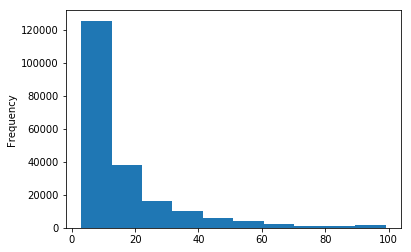

In [14]:
user_order_count.plot(kind='hist')

Looking at order counts by users we wee that most users order between 1 and 20 orders.

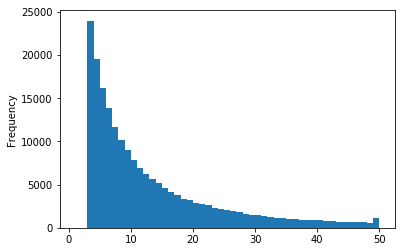

In [15]:
# a closer look at orders between 0 to 50
user_order_count.plot(kind='hist',bins=np.linspace(1,50))

In [26]:
user_order_count.median()

9.0

In [16]:
user_order_count.describe()

count    206209.000000
mean         15.590367
std          16.654774
min           3.000000
25%           5.000000
50%           9.000000
75%          19.000000
max          99.000000
Name: order_number, dtype: float64

206 thousand orders. A range for users orders between 3 and 99 orders. An mean of 16 orders per user and a median of 9 orders. 

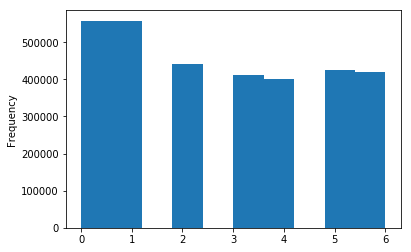

In [17]:
df_prior_set.order_dow.plot(kind='hist')

Lets look at Orders by Day of the Week. What day are people shopping?

Text(0.5,0,u'Orders by Day of the Week')

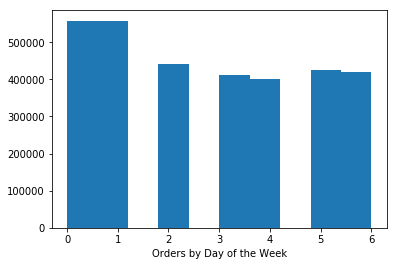

In [19]:
plt.hist(df_prior_set.order_dow)
plt.xlabel("Orders by Day of the Week")

The data set is not clear on which day zero is. The beginning of Instacart week does see the most 
orders with he rest of the week being closely similiar. (It would be a logical assumption that 0 
and 1 represent the weekend, however, we do not know this.)


Lets look at hour of the day. When are most orders received?

Text(0.5,0,u'Orders by Hour of Day')

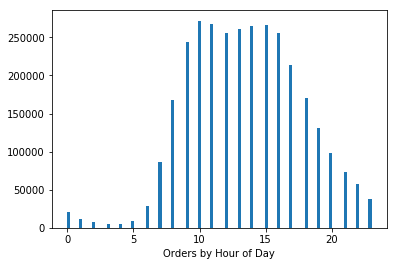

In [25]:
plt.hist(df_prior_set.order_hour_of_day, bins=100)
plt.xlabel('Orders by Hour of Day')


Hour of day indicates most orders between 8am and 8pm which makes sense. 

Looking at Days since prior order:

Text(0.5,0,u'Days since prior order')

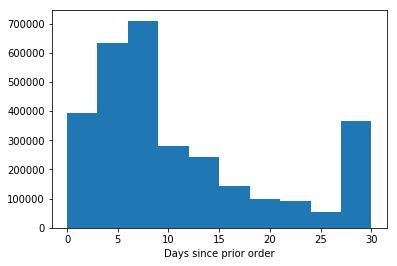

In [27]:
plt.hist(df_prior_set.days_since_prior_order.dropna(),)
plt.xlabel("Days since prior order")

It looks like most orders are followed by another order with in the week. 

The previous data set did not have any describtion on the contents of the order. That information is contained in order_products csv files. Lets explore that for a minute. 

In [28]:
#lets load another chunk of data and look around
instacart_file2=pd.read_csv('Data/order_products__prior.csv')
df_products_prior=pd.DataFrame(instacart_file2,)
df_products_prior.head(12)

,order_id,product_id,add_to_cart_order,reordered
0,2,33120,1,1
1,2,28985,2,1
2,2,9327,3,0
3,2,45918,4,1
4,2,30035,5,0
5,2,17794,6,1
6,2,40141,7,1
7,2,1819,8,1
8,2,43668,9,0
9,3,33754,1,1


We have each order uniquely identified by order id, each product uniquely identified by product_id, the order in which each product was added to the cart and if the product/item was a reorder.

In [29]:
df_products_prior.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32434489 entries, 0 to 32434488
Data columns (total 4 columns):
order_id             int64
product_id           int64
add_to_cart_order    int64
reordered            int64
dtypes: int64(4)
memory usage: 989.8 MB


Lets explore reorders

In [30]:
#group by order_id for reorders
reorders_by_order=df_products_prior['reordered'].groupby(df_products_prior['order_id']).sum()

In [31]:
reorders_by_order.describe()


count    3.214874e+06
mean     5.949389e+00
std      5.842059e+00
min      0.000000e+00
25%      2.000000e+00
50%      4.000000e+00
75%      8.000000e+00
max      1.300000e+02
Name: reordered, dtype: float64

In [33]:
reorders_by_order.median()

4.0

In [ ]:
Reorders per order range from none to 130. Order average almost 6 reorders and a median of 4 reorders.

Text(0.5,0,u'reorders by order')

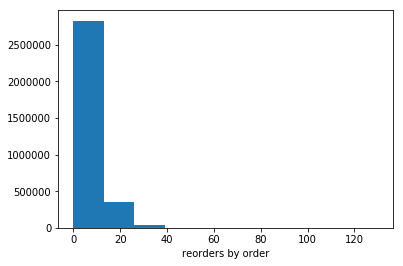

In [32]:
plt.hist(reorders_by_order)
plt.xlabel("reorders by order")


The 130 reorder seems to appear to be an outlier. Most reorders are below 40 with the majority below 20.

Lets look at what portion of the order is reorders.

In [34]:
#count reorders by grouping by order_id on the reordered column
items_in_order=df_products_prior['reordered'].groupby(df_products_prior['order_id']).count()

([<matplotlib.patches.Wedge at 0x1a1473af10>,
 [Text(0.305886,1.05661,u'non-reorders'),
  Text(-0.305886,-1.05661,u'reorders')],
 [Text(0.166847,0.576335,u'41.0%'), Text(-0.166847,-0.576335,u'59.0%')])

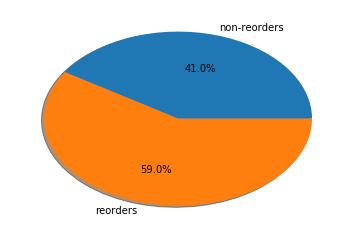

In [35]:
#plot the portion
plt.pie([(items_in_order.sum()-reorders_by_order.sum()),reorders_by_order.sum()],labels=['non-reorders','reorders'],autopct='%1.1f%%', shadow=True)

In [36]:
print(reorders_by_order.sum(),":reordered items",items_in_order.sum(),":items ordered")

(19126536L, ':reordered items', 32434489L, ':items ordered')


Most orders contian around 60% reorders.

In [37]:
print( type(items_in_order),type(reorders_by_order))

(<class 'pandas.core.series.Series'>, <class 'pandas.core.series.Series'>)


In [38]:
df_order_totals=pd.concat([items_in_order,reorders_by_order], axis=1, join='inner',keys=['items_n_order','reorders_n_order'])

In [39]:
df_products_prior.head()

,order_id,product_id,add_to_cart_order,reordered
0,2,33120,1,1
1,2,28985,2,1
2,2,9327,3,0
3,2,45918,4,1
4,2,30035,5,0


In [ ]:
df_products_prior.pivot_table(columns='product_id', )